In [196]:
# Import system packages
import os
import sys
import time
import logging
import importlib
from calendar import day_abbr, month_abbr

#Import data manipulation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from tqdm import tqdm

from imblearn.combine import SMOTEENN

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

from keras import initializers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle

import tensorflow as tf

import random
random.seed(123)

data_path = '../data/'

In [197]:
from train_utils import evaluation, plot_confusion_matrix, plot_roc_curve
from network_LSTM_GAN import *
from train_utils import anomaly_detection

## Specify the current dataset to use
* one_day
* one_week
* one_month

In [198]:
current_dataset = 'one_week'

### Locates dataset with respect to dataset name specified above
The pickled files are generated in `anomaly_detection.ipynb`

In [199]:
if current_dataset == 'one_day':
    with open('dataset_one_day_not_shuffled.pkl', 'rb') as f:
        dataset = pickle.load(f)
elif current_dataset == 'one_week':
    with open('dataset_one_week_not_shuffled.pkl', 'rb') as f:
        dataset = pickle.load(f)
elif current_dataset == 'one_month':
    with open('dataset_one_month_not_shuffled.pkl', 'rb') as f:
        dataset = pickle.load(f)

### Formats the dataframe depending on what dataset was loaded

In [200]:
df_load = pd.read_csv(f'{data_path}/anomaly_labeled_dataset.csv' ,index_col=0)

if current_dataset == 'one_day':
    df = df_load[df_load['dayofweek'] == 5]
    df = df[df['dayofmonth'] == 7]
    df = df[df['monthofyear'] == 7]
    df = df[df['year'] == 2012]
elif current_dataset == 'one_week':
    df = df_load[df_load['monthofyear'] == 7]
    df = df[df['year'] == 2012]
    df = df[(df['dayofmonth'] >=1) & (df['dayofmonth'] <= 7)]
elif current_dataset == 'one_month':
    df = df_load[df_load['monthofyear'] == 7]
    df = df[df['year'] == 2012]

# Initialize parameters

In [201]:
learning_rate = 0.0001
batch_size = 128
epochs = 18
progress_bar = True

Initializes the generator, discriminator and GAN network

In [202]:
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'],dataset['x_test'],dataset['y_test']
adam = Adam(learning_rate=learning_rate)
generator = get_generator_LSTM(adam)
discriminator = get_discriminator_LSTM(adam)
gan = get_gan_network_LSTM(discriminator, generator, adam, input_dim=8)

Runs the actual training, this is a modified version of the one found in `train_utils.py`

In [203]:
batch_count = x_train.shape[0] // batch_size
if progress_bar:
    pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

generated_data = [[] for _ in range(epochs)]
training_data = [[] for _ in range(epochs)]
generated_average = []
training_average = []

for epoch in range(epochs):        
    for index in range(batch_count):  
        if progress_bar:      
            pbar.update(1)        
        # #Obtain a batch of normal network packets
        training_batch = x_train[index * batch_size: (index + 1) * batch_size]
        training_data[epoch].extend(training_batch.flatten())

        # Sample noise and generate a batch of new songs
        noise = np.random.normal(0, 1, (batch_size,8,1))
        gen_imgs = generator.predict(noise)
        generated_data[epoch].extend(gen_imgs.flatten())

        # Train the discriminator (real classified as ones and generated as zeros)
        valid = np.ones((batch_size, 1,1))
        fake = np.zeros((batch_size, 1,1))
        d_loss_real= discriminator.train_on_batch(training_batch, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator 
        g_loss = gan.train_on_batch(noise, valid)

        gan_loss.append(g_loss)
        discriminator_loss.append(d_loss)

    # add rolling average to generated average list
    generated_average.append(pd.Series(generated_data[epoch]).rolling(window=50).mean())
    training_average.append(pd.Series(training_data[epoch]).rolling(window=50).mean())
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))

100%|██████████| 660/660 [51:22<00:00,  4.67s/it]


Epoch 0 Batch 29/30 [D loss: 4.793471] [G loss:4.700064]


Epoch 1 Batch 29/30 [D loss: 4.811137] [G loss:5.437784]


Epoch 2 Batch 29/30 [D loss: 3.714440] [G loss:6.159244]


Epoch 3 Batch 29/30 [D loss: 4.504813] [G loss:5.625778]


Epoch 4 Batch 29/30 [D loss: 4.259151] [G loss:3.125993]


Epoch 5 Batch 29/30 [D loss: 3.698935] [G loss:3.682142]


Epoch 6 Batch 29/30 [D loss: 3.658263] [G loss:5.768188]


Epoch 7 Batch 29/30 [D loss: 3.429518] [G loss:4.899748]


Epoch 8 Batch 29/30 [D loss: 3.874054] [G loss:3.477175]


Epoch 9 Batch 29/30 [D loss: 4.162801] [G loss:2.436880]


Epoch 10 Batch 29/30 [D loss: 3.280064] [G loss:2.649302]


Epoch 11 Batch 29/30 [D loss: 3.002545] [G loss:3.535597]


Epoch 12 Batch 29/30 [D loss: 3.291803] [G loss:3.158030]


Epoch 13 Batch 29/30 [D loss: 3.173264] [G loss:2.334391]


Epoch 14 Batch 29/30 [D loss: 2.868962] [G loss:2.524077]


Epoch 15 Batch 29/30 [D loss: 2.965307] [G loss:4.544333]


Epoch 16 Batch 29/30 [D loss: 3.312196] [G loss:3.333227]


Epoch 17 Batch 29/30 [D loss: 3.259217] [G loss:2.349456]


Plots the training data and the generated data from each epoch overlayed for inspection purposes.
Only shows the last 400 points of each list, modify to show more or less if desired.

To only show from one epoch, comment out the loop and reindent the remainder of the code, thereafter change `i` to the desired epoch

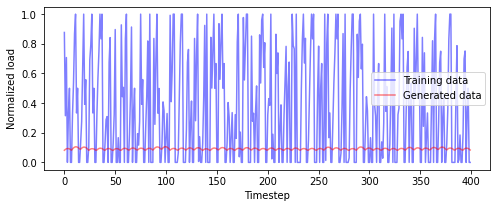

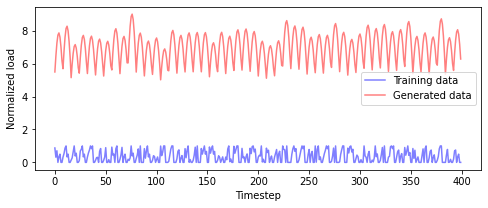

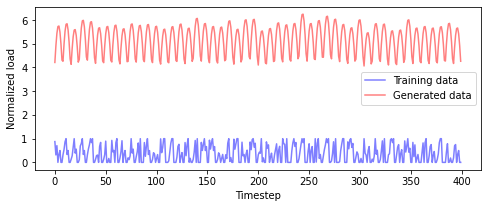

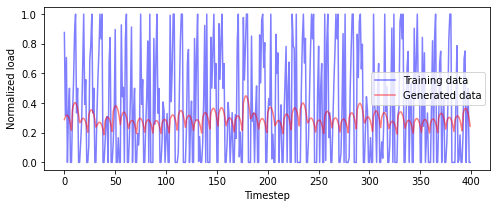

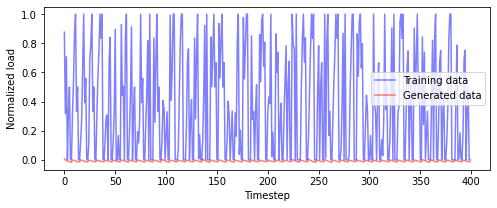

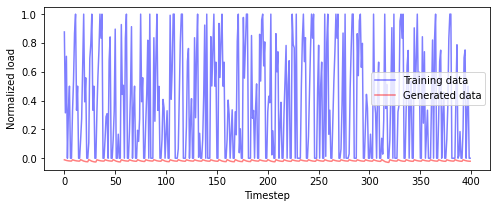

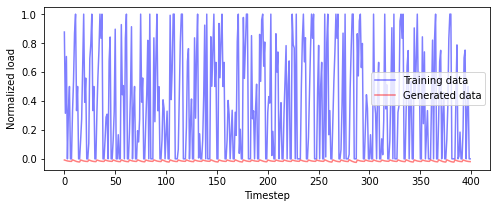

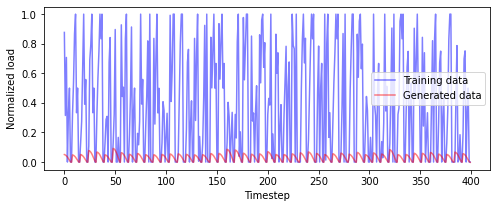

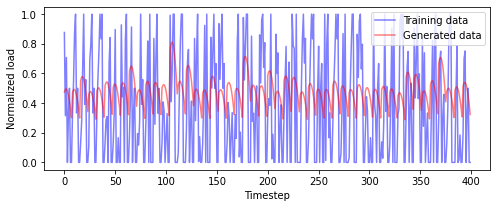

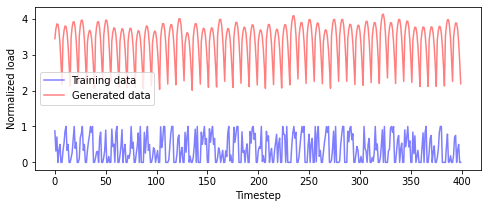

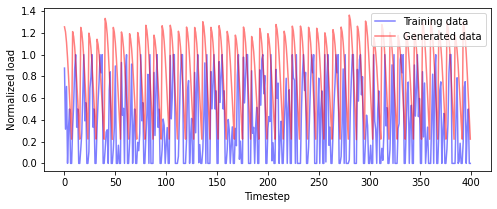

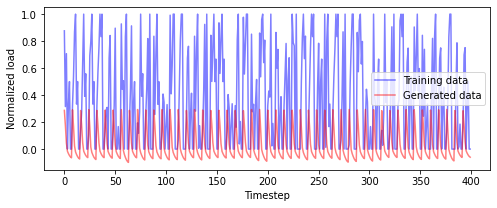

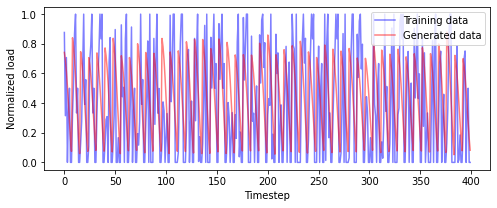

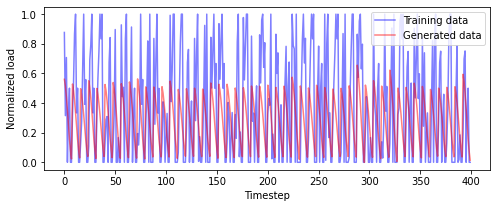

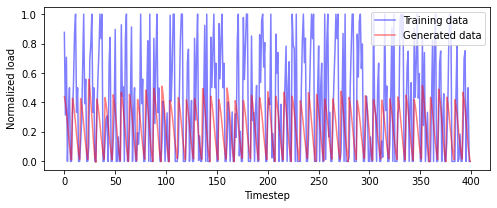

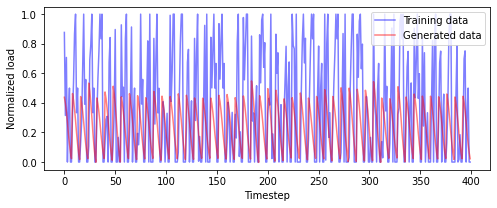

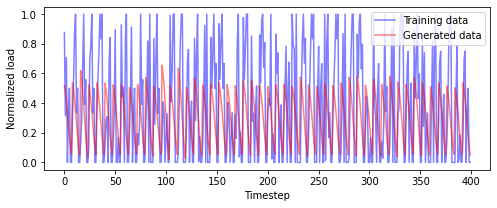

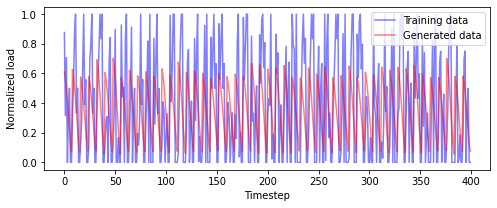

In [204]:
for i in range(epochs):
    y_gen = generated_data[i][-400:]
    x_gen = range(len(y_gen))

    y = training_data[i][-400:]
    x = range(len(y))

    plt.figure(figsize=(8,3))
    plt.plot(x, y, 'b', label='Training data', alpha=0.5)
    plt.plot(x_gen, y_gen, 'r', label='Generated data', alpha=0.5)
    #labels
    plt.xlabel('Timestep')
    plt.ylabel('Normalized load')
    plt.legend()
    plt.show

Plots rolling average of generated data and training data for each epoch
(same as above if it is desired to show for only one epoch)

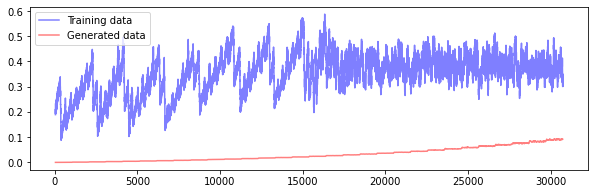

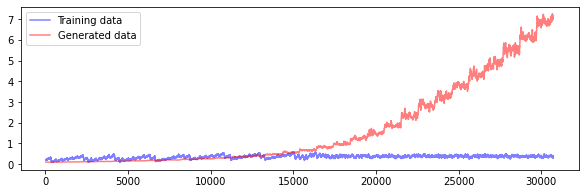

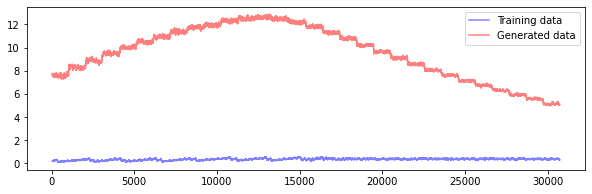

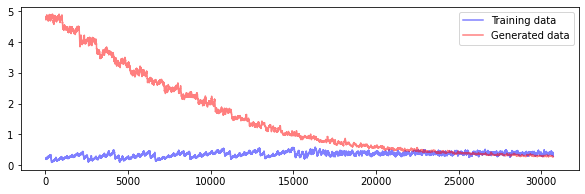

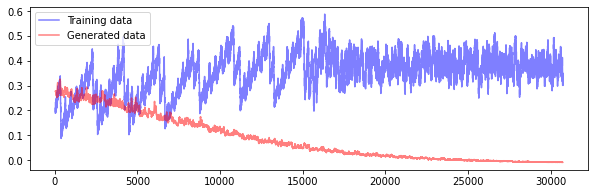

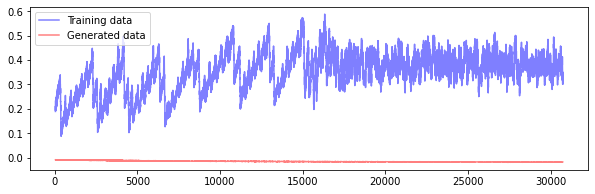

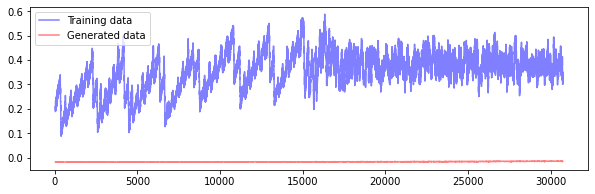

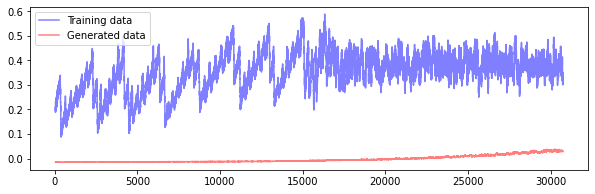

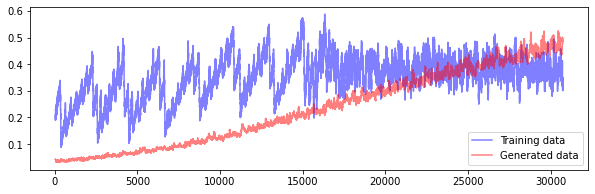

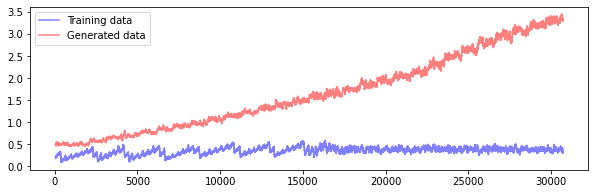

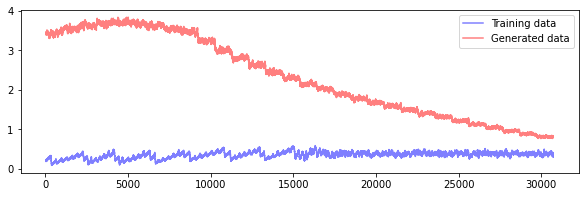

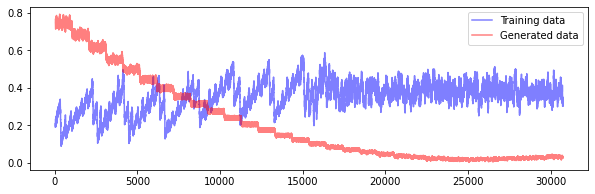

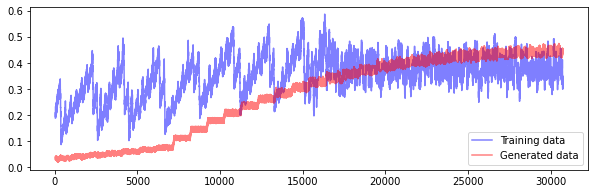

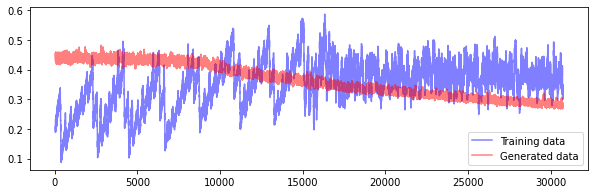

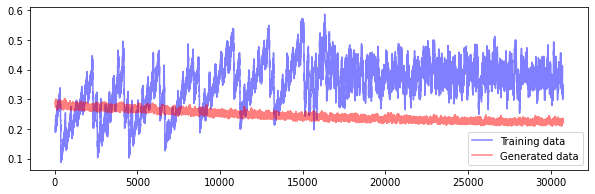

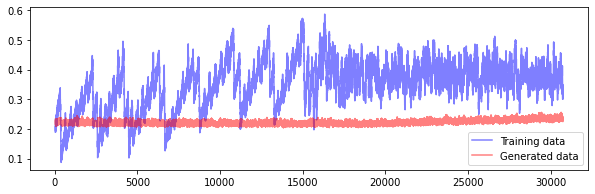

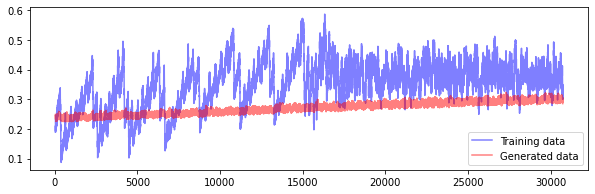

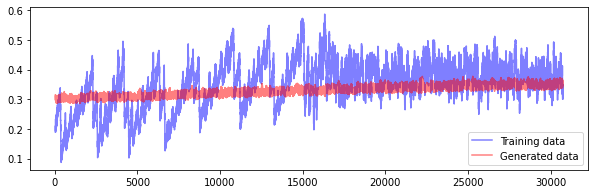

In [215]:
for i in range(epochs):
    y_gen = generated_average[i]
    x_gen = range(len(y_gen))

    y = training_average[i]
    x = range(len(y))

    plt.figure(figsize=(10,3))
    plt.plot(x, y, 'b', label='Training data', alpha=0.5)
    plt.plot(x_gen, y_gen, 'r', label='Generated data', alpha=0.5)
    plt.legend()
    plt.show

Plots the loss of the discriminator and the generator

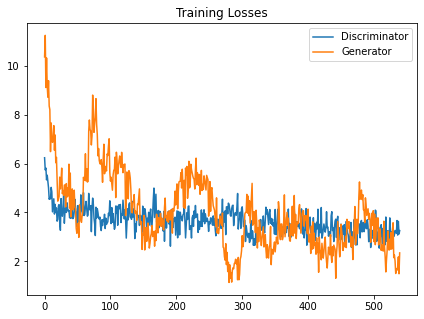

In [206]:
plt.figure(figsize=(7,5))
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

Performs the anomaly detection using the discriminator returned by the training step above

In [207]:
y_pred, result_df = anomaly_detection(x_test, y_test, batch_size, discriminator)
result_df

,results,y_test
0,0.7549016,nan
1,0.7594028,nan
2,0.7546442,nan
3,0.7583671,nan
4,0.7543956,nan
...,...,...
333691,nan,0.0000000
333692,nan,0.0000000
333693,nan,0.0000000
333694,nan,0.0000000


Evaluation, returns (accuracy, precision, recall and f1-score)

In [208]:
evaluation(y_test, y_pred)

(0.9027777777777778,
 0.7272727272727273,
 0.07766990291262135,
 0.14035087719298245)

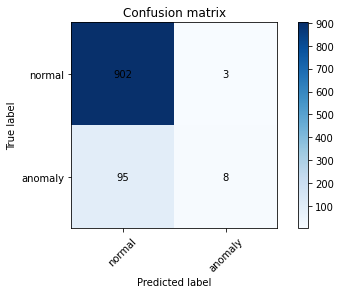

In [209]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

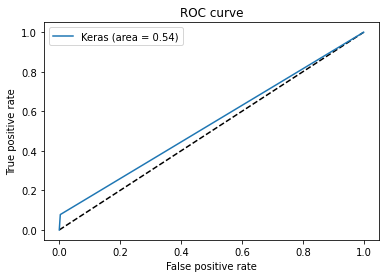

In [210]:
plot_roc_curve(y_test, y_pred)

Locates the indices of the testing data from the main dataset

In [211]:
index_list = y_test.index.values.tolist()
index_list = np.array(index_list, dtype=np.int64)
test_rows = df.loc[index_list]
test_rows

,costumer,GC,hourofday,minuteofhour,dayofweek,dayofmonth,monthofyear,year,Anomaly
263184,202,0.0360000,0,0,6,1,7,2012,0
263185,202,0.0360000,0,30,6,1,7,2012,0
263186,202,0.0280000,1,0,6,1,7,2012,0
263187,202,0.0430000,1,30,6,1,7,2012,0
263188,202,0.0280000,2,0,6,1,7,2012,0
...,...,...,...,...,...,...,...,...,...
333691,215,0.2300000,21,30,5,7,7,2012,0
333692,215,0.2530000,22,0,5,7,7,2012,0
333693,215,0.2760000,22,30,5,7,7,2012,0
333694,215,0.0630000,23,0,5,7,7,2012,0


Reformats the timestamps in the main dataset to a format suitable for plotting

In [212]:
test_rows['timestamp'] = test_rows['year'].astype(str) + '-' + test_rows['monthofyear'].astype(str) + '-' + test_rows['dayofmonth'].astype(str) + 'T' + test_rows['hourofday'].astype(str) + ':' + test_rows['minuteofhour'].astype(str) + ':00'
test_rows['timestamp'] = pd.to_datetime(test_rows['timestamp'])
test_rows['Anomaly'] = y_pred
test_rows

,costumer,GC,hourofday,minuteofhour,dayofweek,dayofmonth,monthofyear,year,Anomaly,timestamp
263184,202,0.0360000,0,0,6,1,7,2012,0.0000000,2012-07-01 00:00:00
263185,202,0.0360000,0,30,6,1,7,2012,0.0000000,2012-07-01 00:30:00
263186,202,0.0280000,1,0,6,1,7,2012,0.0000000,2012-07-01 01:00:00
263187,202,0.0430000,1,30,6,1,7,2012,0.0000000,2012-07-01 01:30:00
263188,202,0.0280000,2,0,6,1,7,2012,0.0000000,2012-07-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...
333691,215,0.2300000,21,30,5,7,7,2012,0.0000000,2012-07-07 21:30:00
333692,215,0.2530000,22,0,5,7,7,2012,0.0000000,2012-07-07 22:00:00
333693,215,0.2760000,22,30,5,7,7,2012,0.0000000,2012-07-07 22:30:00
333694,215,0.0630000,23,0,5,7,7,2012,0.0000000,2012-07-07 23:00:00


Plots predicted anomalies and true anomalies on top of the testing data

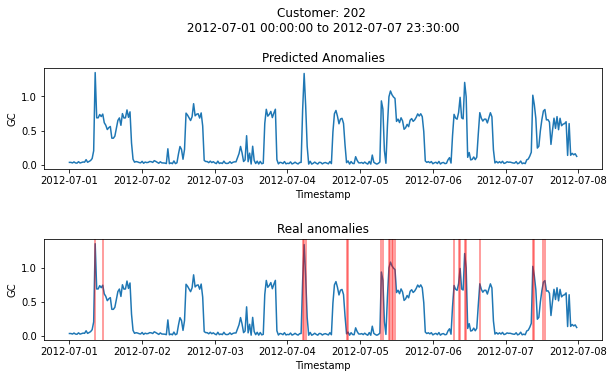

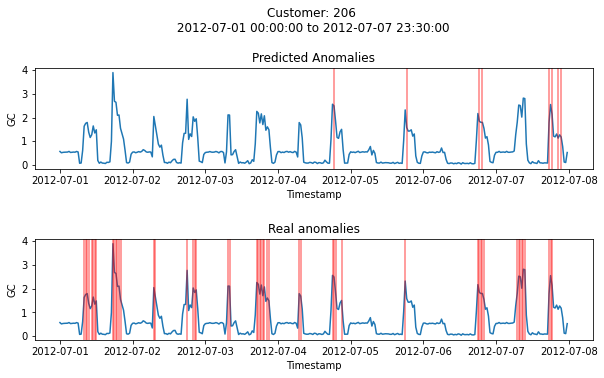

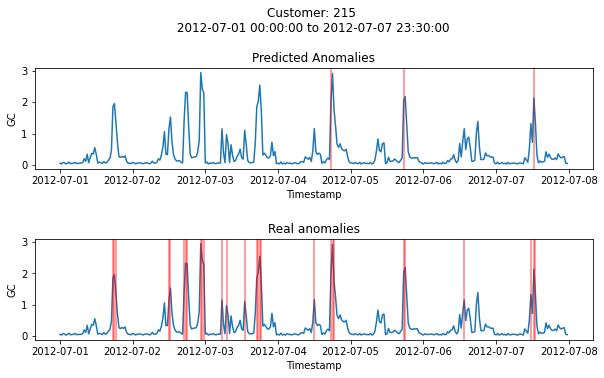

In [213]:
for i, customer in enumerate(test_rows['costumer'].unique()):
    customer_rows = test_rows[test_rows['costumer'] == customer]
    plt.figure(figsize=(10,5))

    plt.subplot(211)
    plt.title(f'Customer: {str(customer)} \n {customer_rows["timestamp"].iloc[0]} to {customer_rows["timestamp"].iloc[-1]} \n\nPredicted Anomalies')
    plt.plot(customer_rows['timestamp'], customer_rows['GC'])
    plt.ylabel('GC')
    plt.xlabel('Timestamp')

    for i, el in enumerate(y_pred[i*len(customer_rows):(i+1)*len(customer_rows)]):
        if el == 1:
            plt.axvline(customer_rows['timestamp'].iloc[i],color='r', alpha=0.5)

    plt.subplot(212, title='Real anomalies')
    plt.plot(customer_rows['timestamp'], customer_rows['GC'])
    plt.ylabel('GC')
    plt.xlabel('Timestamp')
    for i, el in enumerate(y_test.loc[customer_rows.index]):
        if el == 1:
            plt.axvline(customer_rows['timestamp'].iloc[i], color='r', alpha=0.5)

    plt.subplots_adjust(hspace=0.7)
    plt.show()